### Задание 1

* $h(x) = 1, x_i > a$
    * Let's start with a breakpoint. It's clearly 2 as for one dot we can put $a$ after or before x_1 depending on class it belongs to. For 2 the configuration $x_1 < x_2$ $h(x_1) = -h(x_2) = 1$ will not be separable by $a$.
    * As we know, $d_{VC}(h)$ = breakpoint - 1 = 1.
    * Growth function. Given n data points, our hypothesis can only split them into two sets linearly: $x_1, x_2, \ldots, x_i$ and $x_{i + 1}, \ldots, x_n$. where any of the sets can be empty. So there can be $n + 1$ different splits at max giving us $\text{Growth}(h, n) = n + 1$.
* $h(x) = 1, a < x_i < b$
    * Breakpoint. This time the breaking configuration from the previous bullet can be solved with $a < x_1 < b < x_2$, meaning that 2 is not a breakpoint. Breakpoint is 3. $x_1 < x_2 < x_3, h(x_1) = h(x_3) = -h(x_2) = 1$ can't be split with 2 borders so that +1 points are in the middle. 
    * $d_{VC}(h)$ = breakpoint - 1 = 3
    * Growth function. Now we can split set into three: $x_1, \ldots, x_i$ and $x_{i + 1}, \ldots, x_j$ and $x_{j + 1}, \ldots, x_n$. Considering that all configurations with an empty middle set are equivalent: $\text{Growth}(h, n) = \frac{n(n + 1)}{2} + 1$.

In [4]:
import pandas as pd
import plotly
from matplotlib import pyplot as plt
import sklearn
import math
import plotly.plotly as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils

from sklearn.preprocessing import MinMaxScaler

import numpy as np

init_notebook_mode(connected=True)

Using TensorFlow backend.


In [5]:
blobs2_df = pd.read_csv('blobs2.csv', sep=',', header=0)

In [6]:
def split_dataset(df, train_frac):
    # Shuffle
    df = sklearn.utils.shuffle(df)
    sz = len(df.index)
    return df[:int(sz * train_frac)], df[int(sz * train_frac):]

def sgn(w, x):
    return int(w.dot(x) > 0)

def tr_sgn(w, x):
    return sgn(w, np.concatenate((np.array([-1]), x), axis=None))


### Задание 2

In [7]:
def run_pocket_perceptron(df, iters=100):
    w = np.random.uniform(size=len(df.columns))
    best = None
    goodness = None
    sz = len(df.index)
    
    data = df.drop(columns=['label'])
    labels = df['label']
    for _ in range(iters):
        for i in range(sz):
            lab = labels.iat[i]
            x = np.array(data.iloc[i])
            x = np.concatenate((np.array([-1]), x), axis=None)
            if sgn(w, x) != lab:
                w = w + x * (-1. if lab == 0 else 1.)
                break
                
        good = 0
        for i in range(sz):
            lab = labels.iat[i]
            x = np.array(data.iloc[i])
            if tr_sgn(w, x) == lab:
                good += 1
        if goodness is None or good > goodness:
            best = w
    assert best is not None
    return best

In [8]:
blobs_train, blobs_test = split_dataset(blobs2_df, 0.8)
blobs_perceptron = run_pocket_perceptron(blobs_train)

In [41]:
def print_perceptron_metrics(df, perc):
    df_data = df.drop(columns=['label'])
    df_lab = df['label']
    
    
    true_positive =  sum([int(1 == tr_sgn(perc, np.array(df_data.iloc[k])) == df_lab.iloc[k]) for k in range(len(df.index))])
    false_positive = sum([int(1 == tr_sgn(perc, np.array(df_data.iloc[k])) != df_lab.iloc[k]) for k in range(len(df.index))])

    true_negative =  sum([int(0 == tr_sgn(perc, np.array(df_data.iloc[k])) == df_lab.iloc[k]) for k in range(len(df.index))])
    false_negative = sum([int(0 == tr_sgn(perc, np.array(df_data.iloc[k])) != df_lab.iloc[k]) for k in range(len(df.index))])

    accuracy = (true_positive + true_negative) / (true_negative + true_positive + false_negative + false_positive)
    
    print("Validation set: Precision: {}, recall: {}, accuracy: {}".format(
    true_positive / (true_positive + false_positive),
    true_positive / (true_positive + false_negative),
    accuracy))
    
    return accuracy

def draw_perceptron(df, perc):
    df_data = df.drop(columns=['label'])
    df_lab = df['label']
    
    perc_df = pd.DataFrame([perc[1:]], columns=df_data.columns.values)
    perc_line = perc_df[['x', 'y']].values[0]
    
    print(perc)
   
    plotly.offline.iplot([
        go.Scatter(
            x = [-1, 5],
            y = [(perc[0] + perc_line[0]) / perc_line[1], (perc[0] - perc_line[0] * 5) / perc_line[1]],
            mode = 'lines',
            name = 'separating line',
        ),
        go.Scatter(
            y = df[pd.Series([1 == tr_sgn(perc, np.array(df_data.iloc[k])) == df_lab.iloc[k] for k in range(len(df.index))], index=df.index)]['y'],
            x = df[pd.Series([1 == tr_sgn(perc, np.array(df_data.iloc[k])) == df_lab.iloc[k] for k in range(len(df.index))], index=df.index)]['x'],
            mode = 'markers',
            name = 'true +1'
        ),
        go.Scatter(
            y = df[pd.Series([0 == tr_sgn(perc, np.array(df_data.iloc[k])) == df_lab.iloc[k] for k in range(len(df.index))], index=df.index)]['y'],
            x = df[pd.Series([0 == tr_sgn(perc, np.array(df_data.iloc[k])) == df_lab.iloc[k] for k in range(len(df.index))], index=df.index)]['x'],
            mode = 'markers',
            name = 'true -1'
        ),
        go.Scatter(
            y = df[pd.Series([1 == tr_sgn(perc, np.array(df_data.iloc[k])) != df_lab.iloc[k] for k in range(len(df.index))], index=df.index)]['y'],
            x = df[pd.Series([1 == tr_sgn(perc, np.array(df_data.iloc[k])) != df_lab.iloc[k] for k in range(len(df.index))], index=df.index)]['x'],
            mode = 'markers',
            name = 'false +1'
        ),
        go.Scatter(
            y = df[pd.Series([0 == tr_sgn(perc, np.array(df_data.iloc[k])) != df_lab.iloc[k] for k in range(len(df.index))], index=df.index)]['y'],
            x = df[pd.Series([0 == tr_sgn(perc, np.array(df_data.iloc[k])) != df_lab.iloc[k] for k in range(len(df.index))], index=df.index)]['x'],
            mode = 'markers',
            name = 'false -1'
    )], filename='line-mode')

print_perceptron_metrics(blobs_test, blobs_perceptron)
draw_perceptron(blobs_test, blobs_perceptron)

Validation set: Precision: 0.9722222222222222, recall: 1.0, accuracy: 0.985
[-17.64403722   4.10925245  -7.7300518 ]


### Задание 3

In [45]:
new_blobs2_df = blobs2_df.copy()
best_new_blobs_test = [None] * 3
best_new_blobs_perceptron = [None] * 3
best_accuracy = [None] * 3

for x in range(0, 5):
    for y in range(0, 5):
        if x + y < 2 or x + y > 4:
            continue
        new_blobs2_df['z'] = pd.Series([blobs2_df['y'].iat[i]**y * blobs2_df['x'].iat[i]**x for i in range(len(blobs2_df.index))], index=blobs2_df.index)
        new_blobs_train, new_blobs_test = split_dataset(new_blobs2_df, 0.8)
        new_blobs_perceptron = run_pocket_perceptron(new_blobs_train)
        print("Adding dimension x^{}y^{}:".format(x, y), end='')
        accuracy = print_perceptron_metrics(new_blobs_test, new_blobs_perceptron)
        if best_accuracy[x + y - 2] is None or accuracy > best_accuracy[x + y - 2]:
            best_accuracy[x + y - 2] = accuracy
            best_new_blobs_perceptron[x + y - 2] = new_blobs_perceptron
            best_new_blobs_test[x + y - 2] = new_blobs_test
assert best_accuracy[0] is not None
assert best_accuracy[1] is not None
assert best_accuracy[2] is not None

Adding dimension x^0y^2:Validation set: Precision: 0.6624203821656051, recall: 0.9904761904761905, accuracy: 0.73
Adding dimension x^0y^3:Validation set: Precision: 1.0, recall: 0.9032258064516129, accuracy: 0.955
Adding dimension x^0y^4:Validation set: Precision: 1.0, recall: 0.59, accuracy: 0.795
Adding dimension x^1y^1:Validation set: Precision: 1.0, recall: 0.8365384615384616, accuracy: 0.915
Adding dimension x^1y^2:Validation set: Precision: 0.967391304347826, recall: 0.89, accuracy: 0.93
Adding dimension x^1y^3:Validation set: Precision: 0.7934782608695652, recall: 0.8295454545454546, accuracy: 0.83
Adding dimension x^2y^0:Validation set: Precision: 0.9662921348314607, recall: 0.8269230769230769, accuracy: 0.895
Adding dimension x^2y^1:Validation set: Precision: 0.9565217391304348, recall: 0.9649122807017544, accuracy: 0.955
Adding dimension x^2y^2:Validation set: Precision: 0.975, recall: 0.8387096774193549, accuracy: 0.915
Adding dimension x^3y^0:Validation set: Precision: 0.89

In [46]:
for i in range(3):
    print("Best results for degree {}".format(i + 2))
    draw_perceptron(best_new_blobs_test[i], best_new_blobs_perceptron[i])

Best results for degree 2
[ -9.03163851  23.69887732 -15.45376544  -8.1334325 ]


Best results for degree 3
[-55.58339925 140.8519884   97.65265106 -42.01337016]


Best results for degree 4
[-47.96027173 160.694234   -15.11917258 -32.11920721]


### Задание 4

In [151]:
def sigmoid(gamma):
    if gamma > 0:
        return 1. - 1./(1. + math.exp(-gamma))
    else:
        return 1./(1. + math.exp(gamma))

In [176]:
def stochastic_gradient(df, iters=100, forg=1., epochs=1):
    ws = [np.random.uniform(size=len(df.columns))]
    
    def stochastic_gradient_iteration(w, df, forg=1):
        data = df.drop(columns=['label'])
        labels = df['label']
        sz = len(df.index)
        delta = np.zeros(len(w))
        for i in range(sz):
            x = np.array(data.iloc[i])
            x = np.concatenate((np.array([1]), x), axis=None)
            y = -1 if labels.iat[i] == 0 else 1
            delta = delta + x * y * sigmoid(y * w.dot(x))
        return w + forg / sz * delta
    
    sz = len(df.index)
    assert sz >= iters
    batch_sz = sz // iters
    print("Bath size: {}, iterations per epoch: {}, epochs:{}".format(batch_sz, iters, epochs))
    for j in range(epochs):
        shuffled_df = sklearn.utils.shuffle(df)
        for i in range(iters):
            ws.append(stochastic_gradient_iteration(ws[-1], shuffled_df[i * batch_sz:(i + 1) * batch_sz], forg=forg / math.sqrt((i + 1) * (j + 1))))
    return ws

In [177]:
cancer_df = pd.read_csv('cancer.csv', sep=',', header=0)
spam_df   = pd.read_csv('spam.csv'  , sep=',', header=0)

cancer_df['label'] = cancer_df['label'].apply(lambda x: 1 if x == 'M' else 0)

cancer_train, cancer_test = split_dataset(cancer_df, 0.8)
spam_train, spam_test = split_dataset(spam_df, 0.8)

In [191]:
cancer_iters = 20
cancer_epochs = 50
cancer_sgrad = stochastic_gradient(cancer_train, iters=cancer_iters, forg=0.5, epochs=cancer_epochs)

Bath size: 22, iterations per epoch: 20, epochs:50


In [233]:
def decide(w, x):
    return int(w.dot(np.concatenate((np.array([1]), x), axis=None)) > 0)

cancer_test_data = cancer_test.drop(columns=['label'])
cancer_test_lab = cancer_test['label']

plotly.offline.iplot([
go.Scatter(
        y = [sum([int(decide(w, cancer_test_data.iloc[i])
                      == cancer_test_lab.iat[i]) 
                  for i in range(len(cancer_test.index))]) / len(cancer_test.index) for w in cancer_sgrad][::cancer_iters],
        x = list(range(cancer_epochs)),
        mode = 'lines',
        name = 'accuracy'
    )], filename='line-mode')

In [273]:
spam_iters = 200
spam_epochs = 4000
spam_sgrad = stochastic_gradient(spam_train, iters=spam_iters, forg=0.005, epochs=spam_epochs)

Bath size: 18, iterations per epoch: 200, epochs:4000


In [274]:
plotly.offline.iplot([
go.Scatter(
        y = [sum([int(decide(w, spam_test.drop(columns=['label']).iloc[i])
                      == spam_test['label'].iat[i]) 
                  for i in range(len(spam_test.index))]) / len(spam_test.index) for w in spam_sgrad[::spam_iters]],
        x = list(range(spam_epochs)),
        mode = 'lines',
        name = 'accuracy'
    )], filename='line-mode')

### Задание 5

See pictures and datasets for the tasks below. 

### Задание 6

In [260]:
mnist_df = pd.read_csv('mnist.csv', sep=',', header=0)
mnist_df_train, mnist_df_test = split_dataset(mnist_df, 0.8)

Label: 5


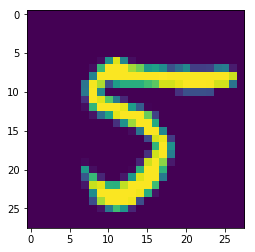

In [261]:
mnist_train_labels = mnist_df_train['label'].values
mnist_train_pics = np.reshape(
    np.array(mnist_df_train.drop(columns=['label']).values), (len(mnist_df_train.index), 28, 28, 1))

mnist_test_labels = mnist_df_test['label'].values
mnist_test_pics = np.reshape(
    np.array(mnist_df_test.drop(columns=['lab el']).values), (len(mnist_df_test.index), 28, 28, 1))

some_pic = 54

print("Label:", mnist_train_labels[some_pic]) 
plt.imshow(np.reshape(mnist_train_pics[some_pic], (28, 28)))

In [262]:
mnist_train_classes = np_utils.to_categorical(mnist_train_labels)
mnist_test_classes = np_utils.to_categorical(mnist_test_labels)
#print(mnist_classes[some_pic])

In [335]:
def get_nmnist_model(activation, size=28):
    nmnist_model = Sequential([
        Convolution2D(8, 3, activation=activation, input_shape=(size, size, 1)),
        Convolution2D(8, 3, activation=activation),
        Convolution2D(8, 3, activation=activation),
        Flatten(),
        Dense(64, activation=activation),
        Dense(64, activation=activation),
        Dense(10, activation='softmax')
    ])
    nmnist_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return nmnist_model

In [269]:
relu_nmnist_model = get_nmnist_model('relu')
sigmoid_nmnist_model = get_nmnist_model('sigmoid')
tanh_nmnist_model = get_nmnist_model('tanh')

In [263]:
relu_nmnist_model.fit(mnist_train_pics, mnist_train_classes,
                      validation_data=(mnist_test_pics, mnist_test_classes), batch_size=32, epochs=10)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 4s 541us/step - loss: 0.0280 - acc: 0.9916 - val_loss: 0.0151 - val_acc: 0.9945
Epoch 2/10
8000/8000 [==============================] - 4s 493us/step - loss: 0.0062 - acc: 0.9984 - val_loss: 0.0179 - val_acc: 0.9955
Epoch 3/10
8000/8000 [==============================] - 4s 553us/step - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0086 - val_acc: 0.9975
Epoch 4/10
8000/8000 [==============================] - 4s 490us/step - loss: 9.0798e-04 - acc: 0.9998 - val_loss: 0.0134 - val_acc: 0.9955
Epoch 5/10
8000/8000 [==============================] - 4s 484us/step - loss: 8.2951e-05 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 0.9970
Epoch 6/10
8000/8000 [==============================] - 4s 520us/step - loss: 2.8798e-05 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9980
Epoch 7/10
8000/8000 [==============================] - 4s 500us/step - loss: 2.0788e-05 - acc: 1.0000 - val_loss: 0.0075 - 

In [267]:
tanh_nmnist_model.fit(mnist_train_pics, mnist_train_classes,
                      validation_data=(mnist_test_pics, mnist_test_classes), batch_size=32, epochs=10)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 5s 580us/step - loss: 0.3784 - acc: 0.8952 - val_loss: 0.1714 - val_acc: 0.9490
Epoch 2/10
8000/8000 [==============================] - 4s 503us/step - loss: 0.1003 - acc: 0.9709 - val_loss: 0.1276 - val_acc: 0.9620
Epoch 3/10
8000/8000 [==============================] - 4s 531us/step - loss: 0.0396 - acc: 0.9906 - val_loss: 0.1094 - val_acc: 0.9660
Epoch 4/10
8000/8000 [==============================] - 4s 494us/step - loss: 0.0166 - acc: 0.9980 - val_loss: 0.1031 - val_acc: 0.9670
Epoch 5/10
8000/8000 [==============================] - 4s 490us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0897 - val_acc: 0.9740
Epoch 6/10
8000/8000 [==============================] - 4s 544us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0907 - val_acc: 0.9750
Epoch 7/10
8000/8000 [==============================] - 4s 513us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0891 - val_acc: 0.9760


In [270]:
sigmoid_nmnist_model.fit(mnist_train_pics, mnist_train_classes,
                      validation_data=(mnist_test_pics, mnist_test_classes), batch_size=32, epochs=10)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 4s 562us/step - loss: 2.3117 - acc: 0.1014 - val_loss: 2.3067 - val_acc: 0.1105
Epoch 2/10
8000/8000 [==============================] - 4s 494us/step - loss: 2.1151 - acc: 0.2436 - val_loss: 1.2501 - val_acc: 0.7990
Epoch 3/10
8000/8000 [==============================] - 4s 494us/step - loss: 0.7028 - acc: 0.8839 - val_loss: 0.4428 - val_acc: 0.9025
Epoch 4/10
8000/8000 [==============================] - 4s 503us/step - loss: 0.3322 - acc: 0.9257 - val_loss: 0.3050 - val_acc: 0.9230
Epoch 5/10
8000/8000 [==============================] - 4s 512us/step - loss: 0.2295 - acc: 0.9440 - val_loss: 0.2657 - val_acc: 0.9265
Epoch 6/10
8000/8000 [==============================] - 4s 515us/step - loss: 0.1778 - acc: 0.9566 - val_loss: 0.2326 - val_acc: 0.9335
Epoch 7/10
8000/8000 [==============================] - 4s 516us/step - loss: 0.1410 - acc: 0.9644 - val_loss: 0.2122 - val_acc: 0.9395


### Задание 7 + 8

In [272]:
from matplotlib.image import imread
import os

In [410]:
cnt_letters = 10

notmnist_pics = []
notmnist_labels = []

for i in range(cnt_letters):
    directory = os.path.join("notMNIST_small", chr(ord('A') + i))
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        if os.path.isfile(filepath) and os.stat(filepath).st_size > 0:
            img = imread(filepath)
            notmnist_labels.append(i)
            notmnist_pics.append(np.array(img))

notmnist_df = pd.DataFrame(data={"label" : notmnist_labels, "pic" : notmnist_pics})

Label: 2
(28, 28)


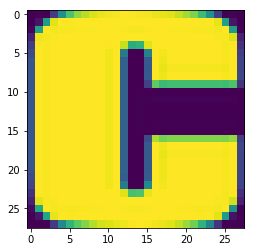

In [411]:
some_pic = 4283

print("Label:", notmnist_labels[some_pic]) 
print(notmnist_pics[some_pic].shape)
plt.imshow(notmnist_pics[some_pic])

In [412]:
notmnist_train_sz = len(notmnist_train_df.index)
notmnist_test_sz = len(notmnist_test_df.index)

notmnist_train_df, notmnist_test_df = split_dataset(notmnist_df, 0.8)
notmnist_train_pic = np.reshape(list(map(np.array, notmnist_train_df['pic'].values)), (notmnist_train_sz, 28, 28, 1))
notmnist_train_lab = notmnist_train_df['label'].values
notmnist_test_pic = np.reshape(list(map(np.array, notmnist_test_df['pic'].values)), (notmnist_test_sz, 28, 28, 1))
notmnist_test_lab = notmnist_test_df['label'].values

In [413]:
notmnist_train_classes = np_utils.to_categorical(notmnist_train_lab)
notmnist_test_classes = np_utils.to_categorical(notmnist_test_lab)

In [425]:
def get_notmnist_model(activation, size=28):
    nmnist_model = Sequential([
        Convolution2D(32, 3, activation=activation, input_shape=(size, size, 1)),
        MaxPooling2D((2,2)),
        Convolution2D(64, 2, activation=activation),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(256, activation=activation),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    nmnist_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return nmnist_model

In [422]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)
dropout_model = get_notmnist_model(activation='relu', size=28)
dropout_model.fit(notmnist_train_pic, notmnist_train_classes,
                      validation_data=(notmnist_test_pic, notmnist_test_classes), batch_size=32, epochs=30, callbacks=[reduce_lr])

Train on 14976 samples, validate on 3744 samples
Epoch 1/30
14976/14976 [==============================] - 39s 3ms/step - loss: 0.5445 - acc: 0.8389 - val_loss: 0.2818 - val_acc: 0.9137
Epoch 2/30
14976/14976 [==============================] - 16s 1ms/step - loss: 0.2756 - acc: 0.9188 - val_loss: 0.2358 - val_acc: 0.9290
Epoch 3/30
14976/14976 [==============================] - 16s 1ms/step - loss: 0.2263 - acc: 0.9309 - val_loss: 0.2118 - val_acc: 0.9348
Epoch 4/30
14976/14976 [==============================] - 16s 1ms/step - loss: 0.1901 - acc: 0.9402 - val_loss: 0.2026 - val_acc: 0.9346
Epoch 5/30
14976/14976 [==============================] - 16s 1ms/step - loss: 0.1645 - acc: 0.9477 - val_loss: 0.1983 - val_acc: 0.9378
Epoch 6/30
14976/14976 [==============================] - 16s 1ms/step - loss: 0.1452 - acc: 0.9537 - val_loss: 0.1930 - val_acc: 0.9407
Epoch 7/30
14976/14976 [==============================] - 16s 1ms/step - loss: 0.1274 - acc: 0.9589 - val_loss: 0.2013 - val_acc:

0.9509 accuracy was reached on 27-th epoch.